In [13]:
import subprocess
from subprocess import PIPE
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob

from typing import List

In [14]:
# Change working directory to the PathTracer
#os.chdir("C:/Users/mathias.gammelmark/Documents/repo/LightSourceImportanceSampling/PathTracer")
os.chdir("../PathTracer")

In [15]:
def run(args:List[str]):
    process = subprocess.Popen(["../bin/Release-windows-x86_64/PathTracer.exe"] + args, stdout=subprocess.PIPE)
    while process.poll() is None:
        output = process.stdout.readline().decode("utf-8").strip()
        if (output is not ''):
            print(output)

def arg_num_samples(n:int):
    return ["-n", str(n)]

def arg_load_obj(filepath:str):
    return ["-obj", filepath]

def arg_scene(files:List[str]):
    res = []
    for file in files:
        res = res + arg_load_obj(file)
    return res

def arg_cam_pos(x:float, y:float, z:float):
    return ["-cam_pos", str(x), str(y), str(z)]

def arg_cam_rot(x:float, y:float, z:float):
    return ["-cam_rot", str(x), str(y), str(z)]

def arg_output(filepath:str):
    return ["-out", filepath]

def arg_outdir(filepath:str):
    if (filepath.endswith("/")):
        return ["-outdir", filepath]
    else:
        return ["-outdir", filepath + "/"]



In [16]:
figure_dpi = 100

def load_profile_from_csv(filepath:str):
    df = pd.read_csv(filepath, header=None).T
    df.columns = df.iloc[0]
    df.drop(0,inplace=True)
    #print("Loaded Profile: {}".format(filepath))
    return df

def load_image_from_csv(filepath:str):
    data = pd.read_csv(filepath).to_numpy()
    #print(np.shape(data))
    img = np.zeros((512,512,3), dtype=np.float)

    for y in range(0,511):
        for x in range(0, 511):
            pixel = data[(511-y)*512 + x][:]
            img[y,x] = pixel

    #print("Loaded Image: {}".format(filepath))
    #return img
    return color_correct(img)

def exposure(img, exposure):
    # reinhard tone mapping
    return img / (img+exposure)

def gamma(img, gamma):
    return np.power(img, 1.0 / gamma)

def color_correct(img):
    return gamma(exposure(img, 1.0), 2.2)

def difference(ImgA, ImgB):
    diff = np.abs(ImgA - ImgB)
    return diff[:,:,0] + diff[:,:,1] + diff[:,:,2]

def show_img(img):
    plt.figure(dpi=figure_dpi)
    plt.imshow(img)
    plt.show()

def show_spectral(img):
    plt.figure(dpi=figure_dpi)
    plt.imshow(img, cmap="coolwarm")
    plt.clim(0, 1)
    plt.colorbar()
    plt.show()

def show_diff_image(imgA, imgB):
    diff = difference(imgA, imgB)
    #diff = np.power(diff,2)
    #diff = exposure(diff, 1.0)
    show_spectral(diff)


In [17]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

def rmse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return np.sqrt(err)

In [18]:
model_cornell = "../Assets/Models/CornellBox.obj"
model_helix = "../Assets/Models/Helix.obj"
model_helix_color = "../Assets/Models/HelixColor.obj"
model_buddha = "../Assets/Models/Buddha.obj"
model_background = "../Assets/Models/Background.obj"
model_bistro_exterior = '../Assets/Models/BistroExterior.obj'

folder_results = "../Test/Results/"
folder_ref = "../Test/Ref/"

cornell_scene_args = arg_scene([model_cornell])
cornell_helix_scene_args = arg_scene([model_cornell, model_helix])

buddha_scene_args = arg_scene([model_buddha, model_helix_color, model_background]) + arg_cam_pos(0.0,1.1,1.3) + arg_cam_rot(-0.5, 0.0, 0.0) + ['-fov','55.0']

bistro_scene_args = arg_scene([model_bistro_exterior]) + arg_cam_pos(2.02,1.78,2.69) + arg_cam_rot(0.01, -1.38, 0.00) + ['-fov', '80.0']


In [19]:
reference_count = 10000
def run_cornell_reference():
    args = []
    args += cornell_scene_args
    args += arg_outdir(folder_ref)
    args += arg_num_samples(reference_count)
    args += ["-method", "naive"]
    args += ["-name", "cornell_ref"]
    run(args)

# Takes a very long time to compute
# run_cornell_reference()

In [20]:
runs = 10
scene_args = cornell_scene_args

method = "lighttree"
attenuation_type = "mindist"
args_additional = []
num_samples = 100
out_folder = folder_results

def run_statistics_test(name:str):
    models = cornell_scene_args
    static_args = (
        scene_args + 
        arg_outdir(folder_results) + 
        ["-method", method] + 
        ["-atten", attenuation_type] + args_additional)

    for samples in [1,10,100]:
        args = static_args
        args += arg_num_samples(samples)
        args += ["-name", name + "_spp_" + str(samples)]
        run(args)

def run_test(name:str):
    args = ['-method', method, '-atten', attenuation_type, '-name', name] + arg_outdir(out_folder) + scene_args + arg_num_samples(num_samples)
    run(args)

def load_statistics_test_data(name:str):
    images = []
    profiles = []
    for samples in [1,2,4,8,16,32,64,128,256]:
        filename = folder_results + name + "_spp_" + str(samples)
        images.append(load_image_from_csv(filename + ".csv"))
        profiles.append(load_profile_from_csv(filename + "_profile.csv"))

    img_ref = load_image_from_csv(folder_ref + "cornell_ref.csv")

    result = pd.concat(profiles)
    error = np.array([mse(img, img_ref) for img in images])
    result['mse'] = error

    result['num_samples'] = result['num_samples'].astype(int)
    result['time_render'] = result['time_render'].astype(float)
    result['time_kernel_shade'] = result['time_kernel_shade'].astype(float)
    result['time_kernel_prepare'] = result['time_kernel_prepare'].astype(float)
    result['time_kernel_trace'] = result['time_kernel_trace'].astype(float)
    result['time_kernel_process_occlusion'] = result['time_kernel_process_occlusion'].astype(float)
    result['time_kernel_process_results'] = result['time_kernel_process_results'].astype(float)

    return result

#run_statistics_test("cornell_lighttree")
#df_lighttree = load_statistics_test_data("cornell_lighttree")
#df_lighttree.to_csv('../Test/lighttree_cornell_total.csv',index=False)
#df_lighttree['cat'] = 'lighttree'

In [21]:
#scene_args = buddha_scene_args
#method = "naive"
#attenuation_type = "mindist"
#args_additional = ['-fov','50.0']
#num_samples = 1000000
#out_folder = folder_ref
#run_test('buddha_ref')

#img_buddha_ref = load_image_from_csv(folder_ref + 'buddha_ref.csv')
#show_img(img_buddha)
#plt.imsave(folder_ref + "BuddhaRef.png", img_buddha)

In [22]:
#scene_args = cornell_scene_args
#method = "naive"
#attenuation_type = "mindist"
#args_additional = []
#num_samples = 1000000
#out_folder = folder_ref
#run_test('cornell_ref')

#img_cornell_ref = load_image_from_csv(folder_ref + 'cornell_ref.csv')
#show_img(img_cornell_ref)
#plt.imsave(folder_ref + "CornellRef.png", img_cornell_ref)

In [23]:
#scene_args = cornell_helix_scene_args
#method = "naive"
#attenuation_type = "mindist"
#args_additional = []
#num_samples = 1000000
#out_folder = folder_ref
#run_test('cornell_helix_ref')

#img_cornell_helix_ref = load_image_from_csv(folder_ref + 'cornell_helix_ref.csv')
#show_img(img_cornell_helix_ref)
#plt.imsave(folder_ref + "CornellHelixRef.png", img_cornell_helix_ref)

In [24]:
#scene_args = bistro_scene_args
#method = "naive"
#attenuation_type = "mindist"
#args_additional = []
#num_samples = 100000
#out_folder = folder_ref
#run_test('bistro_ref2')

#img_bistro_ref = load_image_from_csv(out_folder + 'bistro_ref2_data.csv')
#show_img(img_bistro_ref)
#plt.imsave(out_folder + "BistroRef2.png", img_bistro_ref)

In [25]:
def run_method_test(scene:List[str], name:str):
    for method in ['lighttree', 'spatial', 'energy','naive']:
        for samples in [1,10,100]:
            for i in range(0,10):
                args = list()
                args.extend(scene)
                args.extend(arg_num_samples(samples))
                args.extend(['-method', method])
                args.extend(arg_outdir('../Test/Method'))
                args.extend(['-name', name + '_' + method + '_spp' + str(samples) + '_n' + str(i)])
                run(args)


In [26]:
#run_method_test(cornell_scene_args, 'cornell')

  : 0.743584ms
- kernel_shade    : 0.560352ms
- kernel_p_occ    : 0.000000ms
- kernel_p_res    : 0.025824ms
- Build BVH         : 0.067900ms
- Build Lighttree   : 0.000000ms
- Num Samples       : 1
- Num Num Lights    : 2
- Num Primitives    : 32
Total Time: 1167.01ms
Application Destroyed
Platform: NVIDIA CUDA 
Device: GeForce RTX 2080 
Application Initialized
Loading Object: ../Assets/Models/CornellBox.obj
Set Target Number of samples: 1, 1
Loaded mesh: ../Assets/Models/CornellBox.obj
resolution: [512,512]SAH BVH Builder: 0ms
Waiting for scene to load
Upload Complete
faces: 32, vertices: 64, materials: 8
PointLights: 2, MeshLights: 2
SAH BVH Builder: 0.1ms
Start Rendering
Rendering Complete
Results:
- Render Time       : 6.816700ms
- Render Overhead   : 5.394268ms
- kernel_prep     : 0.071264ms
- kernel_trace    : 0.760608ms
- kernel_shade    : 0.565312ms
- kernel_p_occ    : 0.000000ms
- kernel_p_res    : 0.025248ms
- Build BVH         : 0.152100ms
- Build Lighttree   : 0.000000ms
- 

In [27]:
#run_method_test(cornell_helix_scene_args, 'helix')

 ../Assets/Models/CornellBox.obj
Loaded mesh: ../Assets/Models/Helix.obj
resolution: [512,512]SAH BVH Builder: 0ms
Waiting for scene to load
Upload Complete
Upload Complete
faces: 1292, vertices: 2862, materials: 9
PointLights: 1262, MeshLights: 1262
SAH BVH Builder: 1.236ms
Start Rendering
[10,10]: 100.00 pct
Rendering Complete
Results:
- Render Time       : 28.833400ms
- Render Overhead   : 5.276248ms
- kernel_prep     : 0.695968ms
- kernel_trace    : 16.077856ms
- kernel_shade    : 6.415456ms
- kernel_p_occ    : 0.000000ms
- kernel_p_res    : 0.367872ms
- Build BVH         : 1.260300ms
- Build Lighttree   : 0.000000ms
- Num Samples       : 10
- Num Num Lights    : 1262
- Num Primitives    : 1292
Total Time: 1224.33ms
Application Destroyed
Platform: NVIDIA CUDA 
Device: GeForce RTX 2080 
Application Initialized
Loading Object: ../Assets/Models/CornellBox.obj
Loading Object: ../Assets/Models/Helix.obj
Set Target Number of samples: 10, 10
Loaded mesh: ../Assets/Models/CornellBox.obj
Lo

In [28]:
#run_method_test(buddha_scene_args, 'buddha')

100.00 pct
Rendering Complete
Results:
- Render Time       : 63.230000ms
- Render Overhead   : 4.753136ms
- kernel_prep     : 0.697440ms
- kernel_trace    : 53.212064ms
- kernel_shade    : 4.211424ms
- kernel_p_occ    : 0.000000ms
- kernel_p_res    : 0.355936ms
- Build BVH         : 1524.924800ms
- Build Lighttree   : 0.000000ms
- Num Samples       : 10
- Num Num Lights    : 1260
- Num Primitives    : 1088715
Total Time: 2864.67ms
Application Destroyed
Platform: NVIDIA CUDA 
Device: GeForce RTX 2080 
Application Initialized
Loading Object: ../Assets/Models/Buddha.obj
Loading Object: ../Assets/Models/HelixColor.obj
Loading Object: ../Assets/Models/Background.obj
fov: 55.000000
Set Target Number of samples: 10, 10
Loaded mesh: ../Assets/Models/Background.obj
Loaded mesh: ../Assets/Models/HelixColor.obj
resolution: [512,512]SAH BVH Builder: 0ms
Waiting for scene to load
Loaded mesh: ../Assets/Models/Buddha.obj
Upload Complete
Upload Complete
Upload Complete
faces: 1088715, vertices: 55400

In [29]:
#run_method_test(bistro_scene_args, 'bistro')

 Object: ../Assets/Models/BistroExterior.obj
fov: 80.000000
Set Target Number of samples: 10, 10
resolution: [512,512]SAH BVH Builder: 0ms
Waiting for scene to load
Loaded mesh: ../Assets/Models/BistroExterior.obj
Upload Complete
faces: 2829801, vertices: 2983978, materials: 132
PointLights: 32368, MeshLights: 32368
SAH BVH Builder: 3627.69ms
Start Rendering
[10,10]: 100.00 pct
Rendering Complete
Results:
- Render Time       : 638.881500ms
- Render Overhead   : 3.845500ms
- kernel_prep     : 0.689248ms
- kernel_trace    : 627.452384ms
- kernel_shade    : 6.400032ms
- kernel_p_occ    : 0.000000ms
- kernel_p_res    : 0.494336ms
- Build BVH         : 3627.713400ms
- Build Lighttree   : 0.000000ms
- Num Samples       : 10
- Num Num Lights    : 32368
- Num Primitives    : 2829801
Total Time: 5762.4ms
Application Destroyed
Platform: NVIDIA CUDA 
Device: GeForce RTX 2080 
Application Initialized
Loading Object: ../Assets/Models/BistroExterior.obj
fov: 80.000000
Set Target Number of samples: 1

In [30]:
def process_method_tests(name:str, reference):
    dataframes = list()
    for i in range(0,10):
        for samples in [1,10,100]:
            name_naive = '../Test/Method/' + name + '_naive' + '_spp' + str(samples) + '_n' + str(i)
            name_energy = '../Test/Method/' + name + '_energy' + '_spp' + str(samples) + '_n' + str(i)
            name_spatial = '../Test/Method/' + name + '_spatial' + '_spp' + str(samples) + '_n' + str(i)
            name_lighttree = '../Test/Method/' + name + '_lighttree' + '_spp' + str(samples) + '_n' + str(i)
            tmp = pd.DataFrame()
            tmp['num_samples'] = [samples]
            tmp['naive'] = [rmse(load_image_from_csv(name_naive + '_data.csv'), reference)]
            tmp['energy'] = [rmse(load_image_from_csv(name_energy + '_data.csv'), reference)]
            tmp['spatial'] = [rmse(load_image_from_csv(name_spatial + '_data.csv'), reference)]
            tmp['lighttree'] = [rmse(load_image_from_csv(name_lighttree + '_data.csv'), reference)]
            tmp['time_naive'] = [load_profile_from_csv(name_naive + '_profile.csv')['time_render']]
            tmp['time_energy'] = [load_profile_from_csv(name_energy + '_profile.csv')['time_render']]
            tmp['time_spatial'] = [load_profile_from_csv(name_spatial + '_profile.csv')['time_render']]
            tmp['time_lighttree'] = [load_profile_from_csv(name_lighttree + '_profile.csv')['time_render']]
            dataframes.append(tmp)
    
    df = pd.concat(dataframes)
    df['time_naive'] = df['time_naive'].astype(float)
    df['time_energy'] = df['time_energy'].astype(float)
    df['time_spatial'] = df['time_spatial'].astype(float)
    df['time_lighttree'] = df['time_lighttree'].astype(float)
    df.groupby('num_samples')['naive','energy','spatial','lighttree'].mean().plot(kind='bar')
    df.groupby('num_samples')['time_naive','time_energy','time_spatial','time_lighttree'].mean().plot(kind='bar')
    plt.show()
    return df

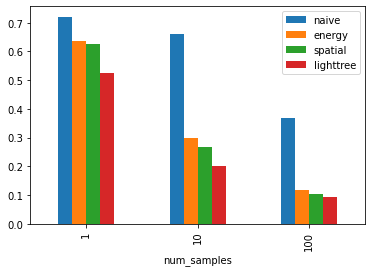

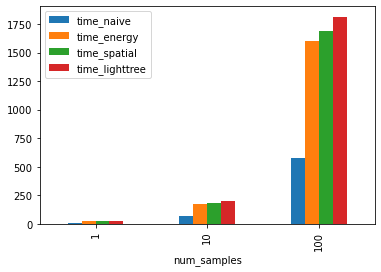

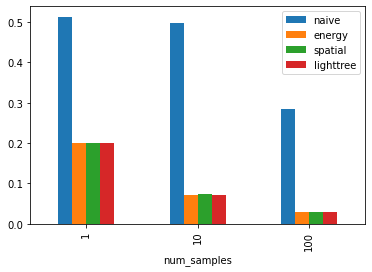

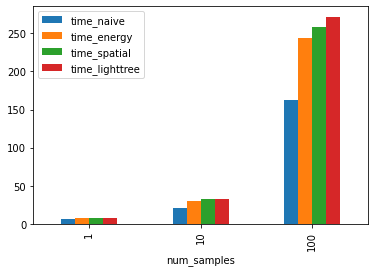

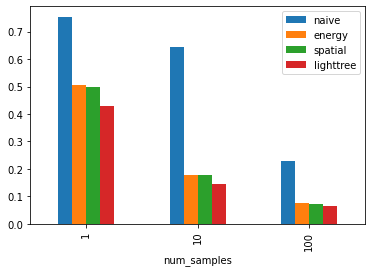

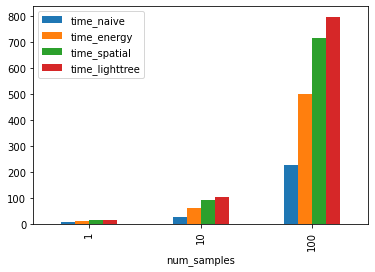

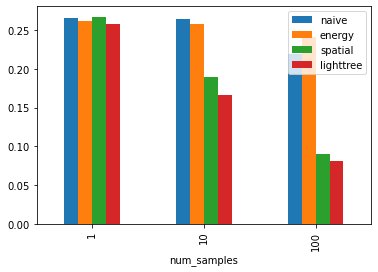

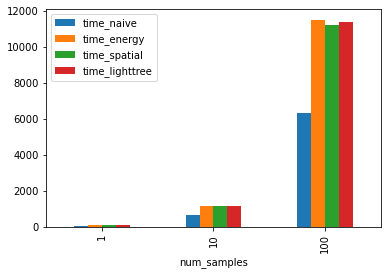

In [33]:
img_buddha_ref = load_image_from_csv('../Test/Ref/buddha_ref.csv')
img_cornell_ref = load_image_from_csv('../Test/Ref/cornell_ref.csv')
img_cornell_helix_ref = load_image_from_csv('../Test/Ref/cornell_helix_ref.csv')
img_bistro_ref = load_image_from_csv('../Test/Ref/bistro_ref2_data.csv')

process_method_tests('buddha',img_buddha_ref).to_csv('../Test/method_buddha.csv')
process_method_tests('cornell', img_cornell_ref).to_csv('../Test/method_cornell.csv')
process_method_tests('helix', img_cornell_helix_ref).to_csv('../Test/method_helix.csv')
process_method_tests('bistro',img_bistro_ref).to_csv('../Test/method_bistro.csv')

In [ ]:
def initial_results_images():
    buddha_ref = load_image_from_csv('../Test/Ref/buddha_ref.csv')
    buddha_naive = load_image_from_csv('../Test/Method/buddha_naive_spp10_n0_data.csv')
    buddha_energy = load_image_from_csv('../Test/Method/buddha_energy_spp10_n0_data.csv')
    buddha_spatial = load_image_from_csv('../Test/Method/buddha_spatial_spp10_n0_data.csv')
    buddha_lighttree = load_image_from_csv('../Test/Method/buddha_lighttree_spp10_n0_data.csv')
    plt.imsave('../Test/buddha_naive10.png', buddha_naive)
    plt.imsave('../Test/buddha_energy10.png', buddha_energy)
    plt.imsave('../Test/buddha_spatial10.png', buddha_spatial)
    plt.imsave('../Test/buddha_lighttree10.png', buddha_lighttree)
    print('Naive: {:.3f}'.format(rmse(buddha_naive,buddha_ref)))
    show_diff_image(buddha_naive, buddha_ref)
    print('Energy: {:.3f}'.format(rmse(buddha_energy,buddha_ref)))
    show_diff_image(buddha_energy, buddha_ref)
    print('Spatial: {:.3f}'.format(rmse(buddha_spatial,buddha_ref)))
    show_diff_image(buddha_spatial, buddha_ref)
    print('Lighttree: {:.3f}'.format(rmse(buddha_lighttree,buddha_ref)))
    show_diff_image(buddha_lighttree, buddha_ref)
    

initial_results_images()
